<a href="https://colab.research.google.com/github/hochthom/OG-AI4Artists-2023/blob/main/Image-Generation/ai4artists_image_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 1. Setup

We are using detectron2 library, since it has many different [pretrained models](https://github.com/facebookresearch/detectron2/blob/main/MODEL_ZOO.md) available!

In [ ]:
!python -m pip install pyyaml==5.1
import sys, os, distutils.core
# Note: This is a faster way to install detectron2 in Colab, but it does not include all functionalities.
# See https://detectron2.readthedocs.io/tutorials/install.html for full installation instructions
!git clone 'https://github.com/facebookresearch/detectron2'
dist = distutils.core.run_setup("./detectron2/setup.py")
!python -m pip install {' '.join([f"'{x}'" for x in dist.install_requires])}
sys.path.insert(0, os.path.abspath('./detectron2'))

# Properly install detectron2. (Please do not install twice in both ways)
# !python -m pip install 'git+https://github.com/facebookresearch/detectron2.git'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyyaml: filename=PyYAML-5.1-cp39-cp39-linux_x86_64.whl size=44089 sha256=fe750600206fc7a0a7e4666730cf0869d0b9e048f1c33e906f6ec0d31cc34de1
  Stored in directory: /root/.cache/pip/wheels/68/be/8f/b6c454cd264e0b349b47f8ee00755511f277618af9e5dae20d
Successfully built pyyaml
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 6.0
    Uninstalling PyYAML-6.0:
      Successfully uninstalled PyYAML-6.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
flax 0.6.8 requires PyYAML>=5.4.1, but you have pyyaml 5.1 which is incompatible.
dask 2022.12.1 requires pyyaml>=5.3.1, but you have pyyaml 5.1 which is incompatible.

In [ ]:
import torch, detectron2
!nvcc --version
TORCH_VERSION = ".".join(torch.__version__.split(".")[:2])
CUDA_VERSION = torch.__version__.split("+")[-1]
print("torch: ", TORCH_VERSION, "; cuda: ", CUDA_VERSION)
print("detectron2:", detectron2.__version__)

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:33:58_PDT_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0
torch:  2.0 ; cuda:  cu118
detectron2: 0.6


In [ ]:
# Some basic setup:
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random
from google.colab.patches import cv2_imshow

# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

# 2. Run a pre-trained detectron2 model

First we upload the image which we want to segment.

In [ ]:
!wget http://images.cocodataset.org/val2017/000000439715.jpg -q -O input.jpg

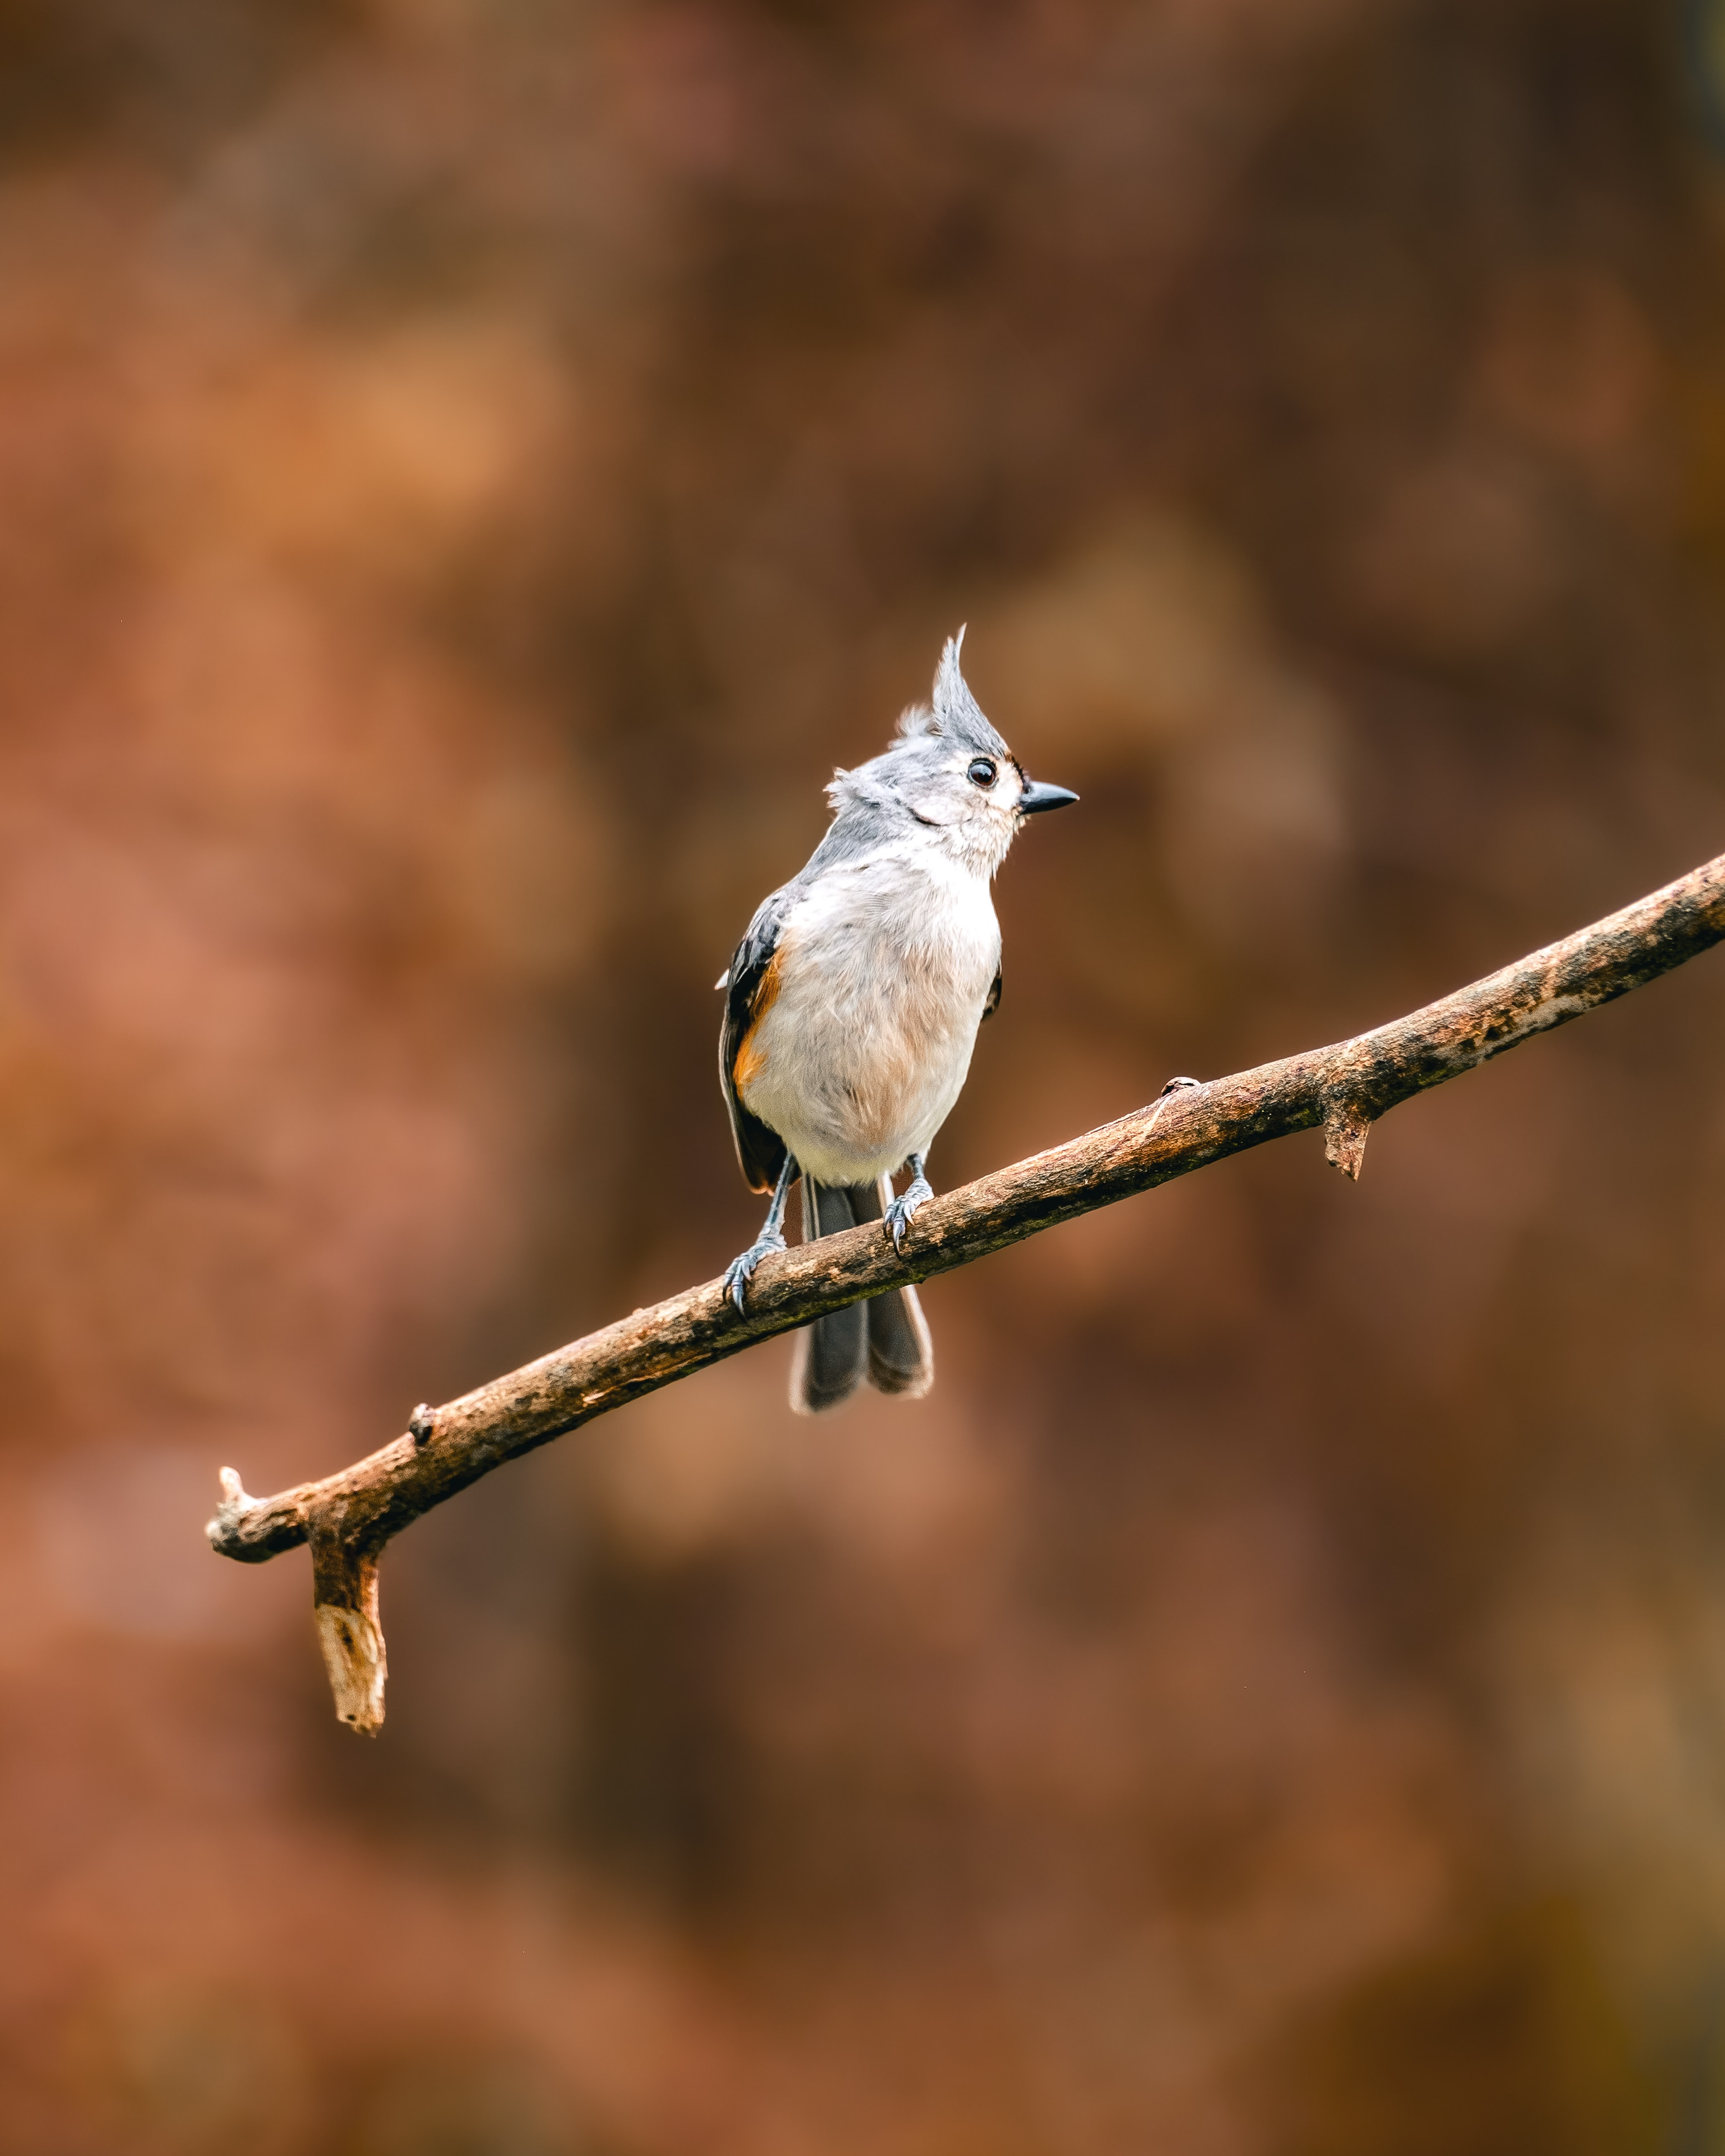

In [ ]:
filename = './daniel-shapiro-Ljm80tZkVLc-unsplash.jpg'
im = cv2.imread(filename)
cv2_imshow(im)

Then, we create a detectron2 config and a detectron2 `DefaultPredictor` to run inference on this image.

In [ ]:
# Inference with a panoptic segmentation model
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml"))
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-PanopticSegmentation/panoptic_fpn_R_101_3x.yaml")
predictor = DefaultPredictor(cfg)

[04/21 07:17:24 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-PanopticSegmentation/panoptic_fpn_R_101_3x/139514519/model_final_cafdb1.pkl ...


model_final_cafdb1.pkl: 261MB [00:01, 196MB/s]                           


Here is the actual inference step

In [ ]:
panoptic_seg, segments_info = predictor(im)["panoptic_seg"]

Finally, we visualize the segmentation result

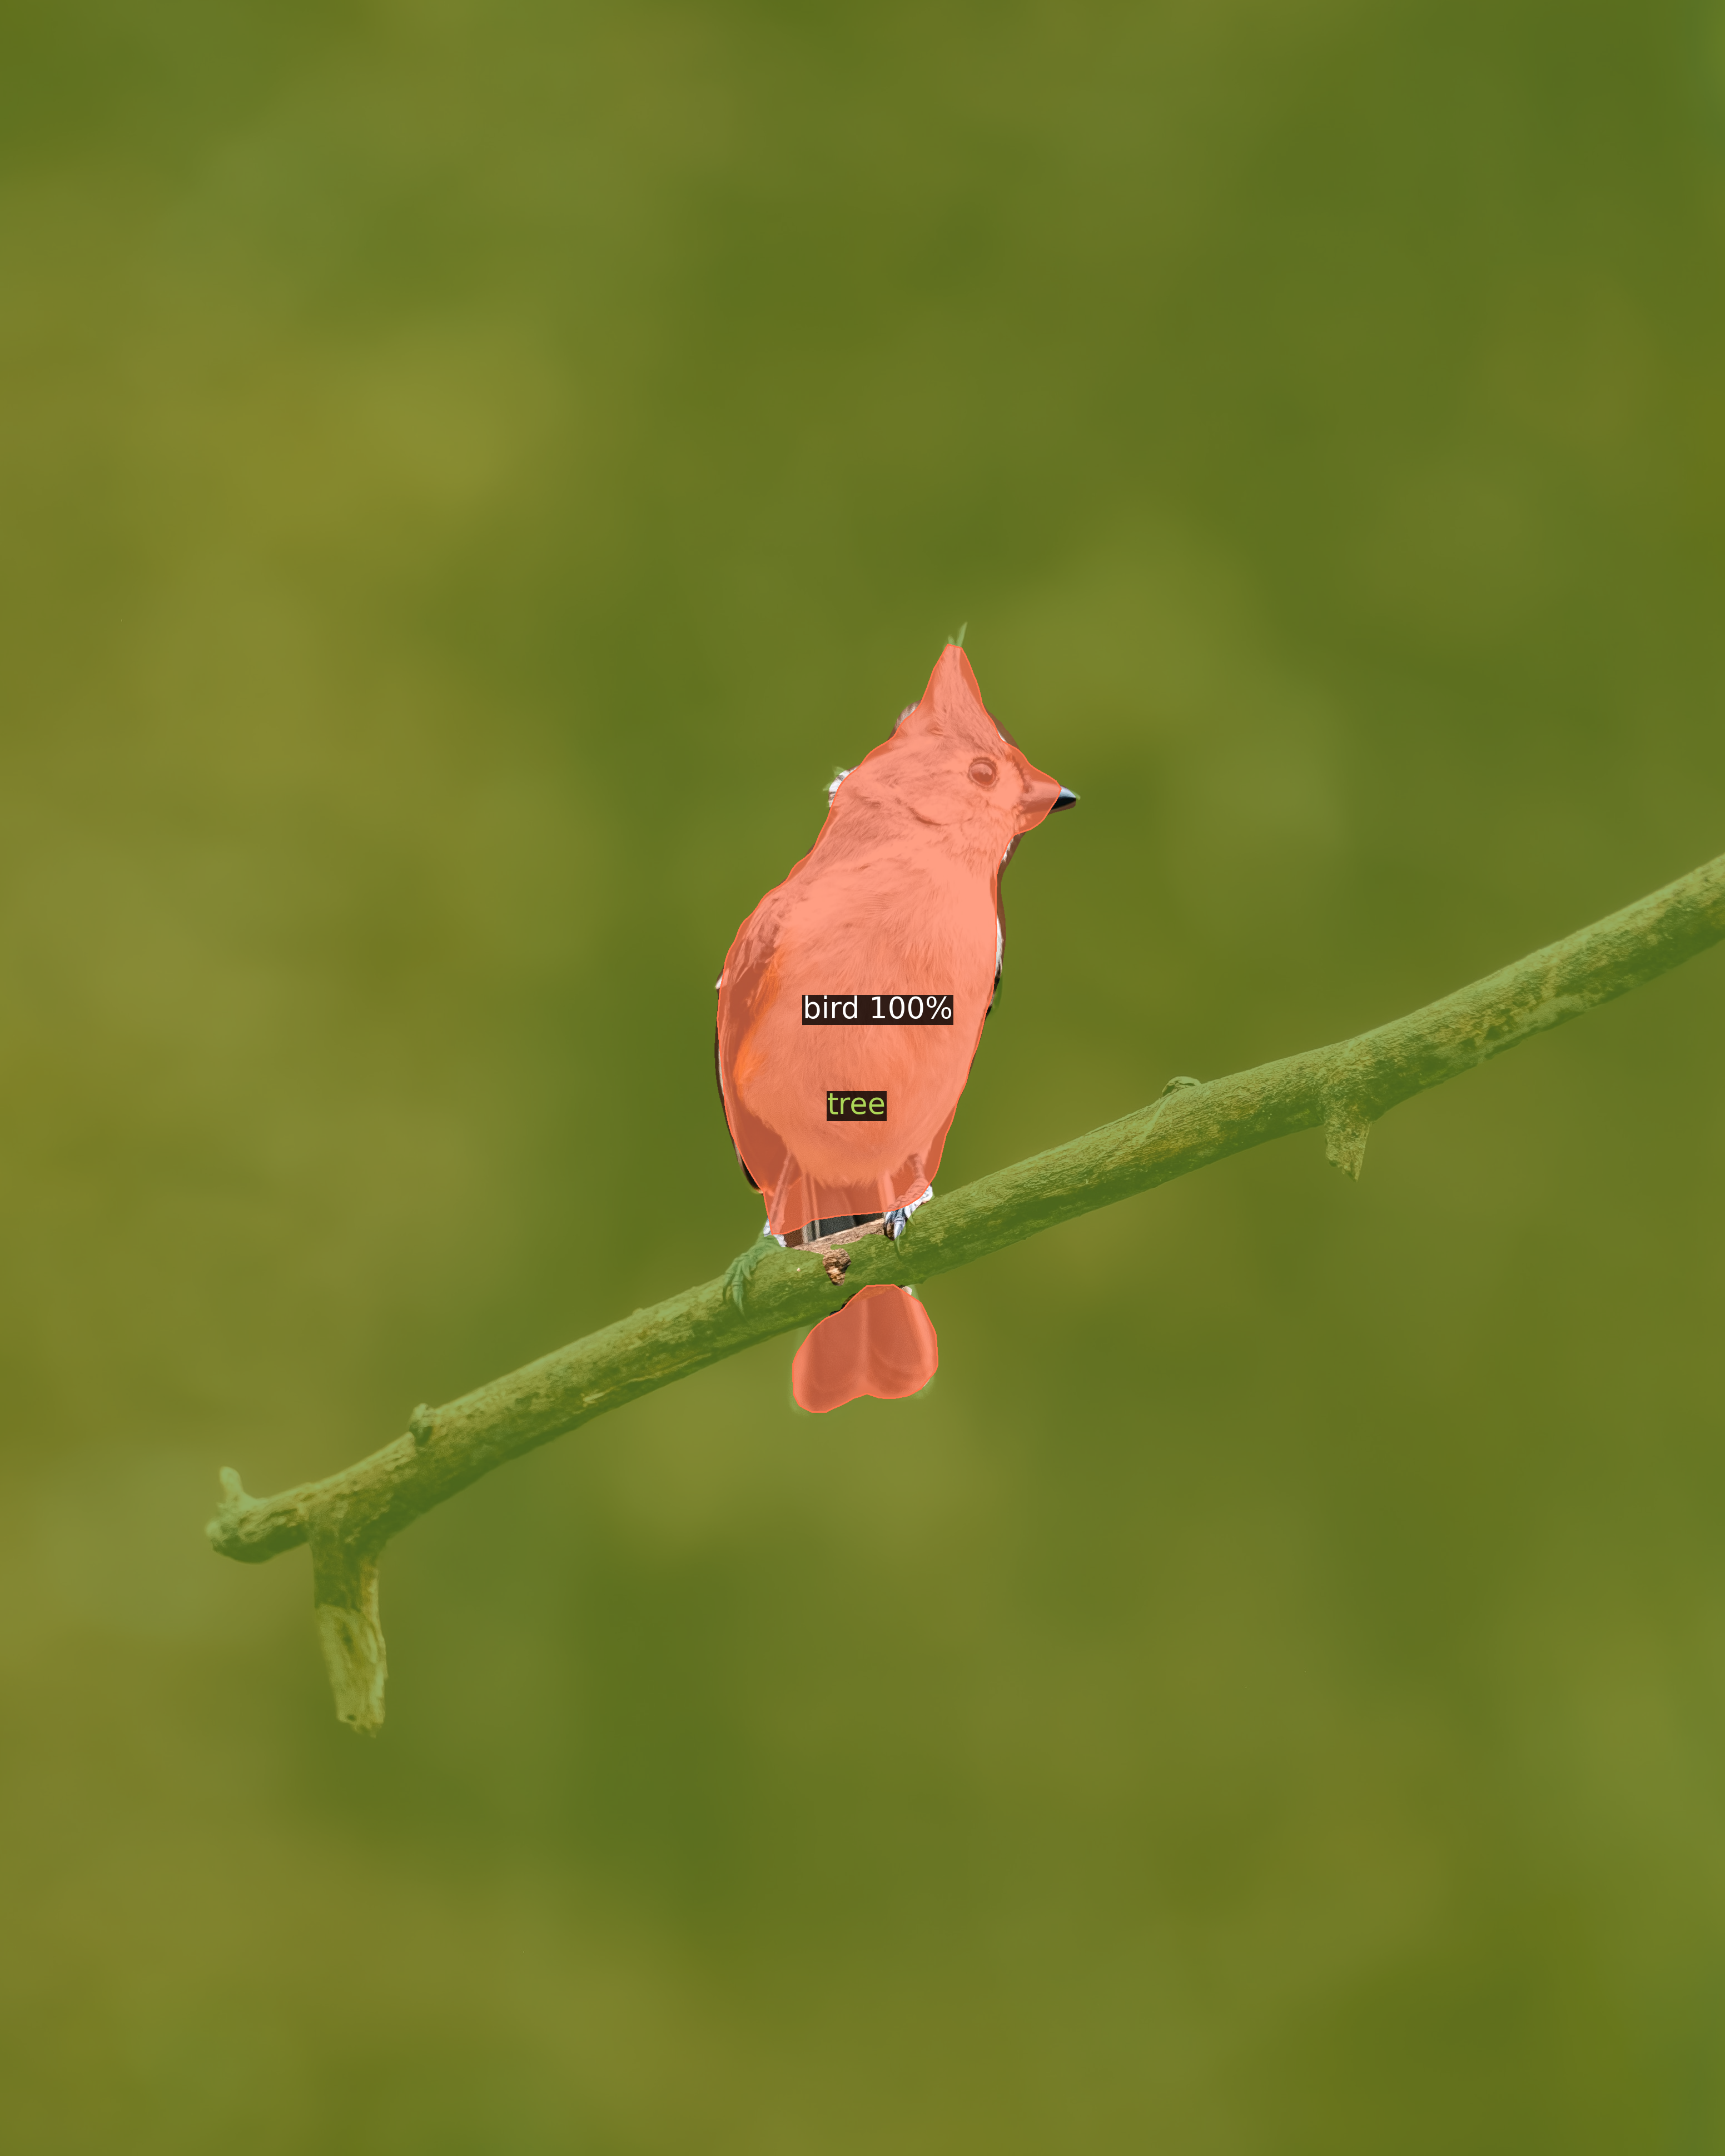

In [ ]:
cat = MetadataCatalog.get(cfg.DATASETS.TRAIN[0])
v = Visualizer(im[:, :, ::-1], cat, scale=1.0)
out = v.draw_panoptic_seg_predictions(panoptic_seg.to("cpu"), segments_info)
cv2_imshow(out.get_image()[:, :, ::-1])

# 3. Creating a mask

In [ ]:
is_thing = True
cat_id = cat.thing_classes.index('bird')
#cat_id = cat.stuff_classes.index('grass')


In [ ]:
# find segments with cat_id
idx = []
for seg in segments_info:
  if seg['isthing']==is_thing and seg['category_id'] == cat_id:
    idx.append(seg['id'])

# create mask
mask = panoptic_seg.to("cpu").detach().numpy()
mask = np.isin(mask, idx)
mask = mask.astype(np.int8) * 255

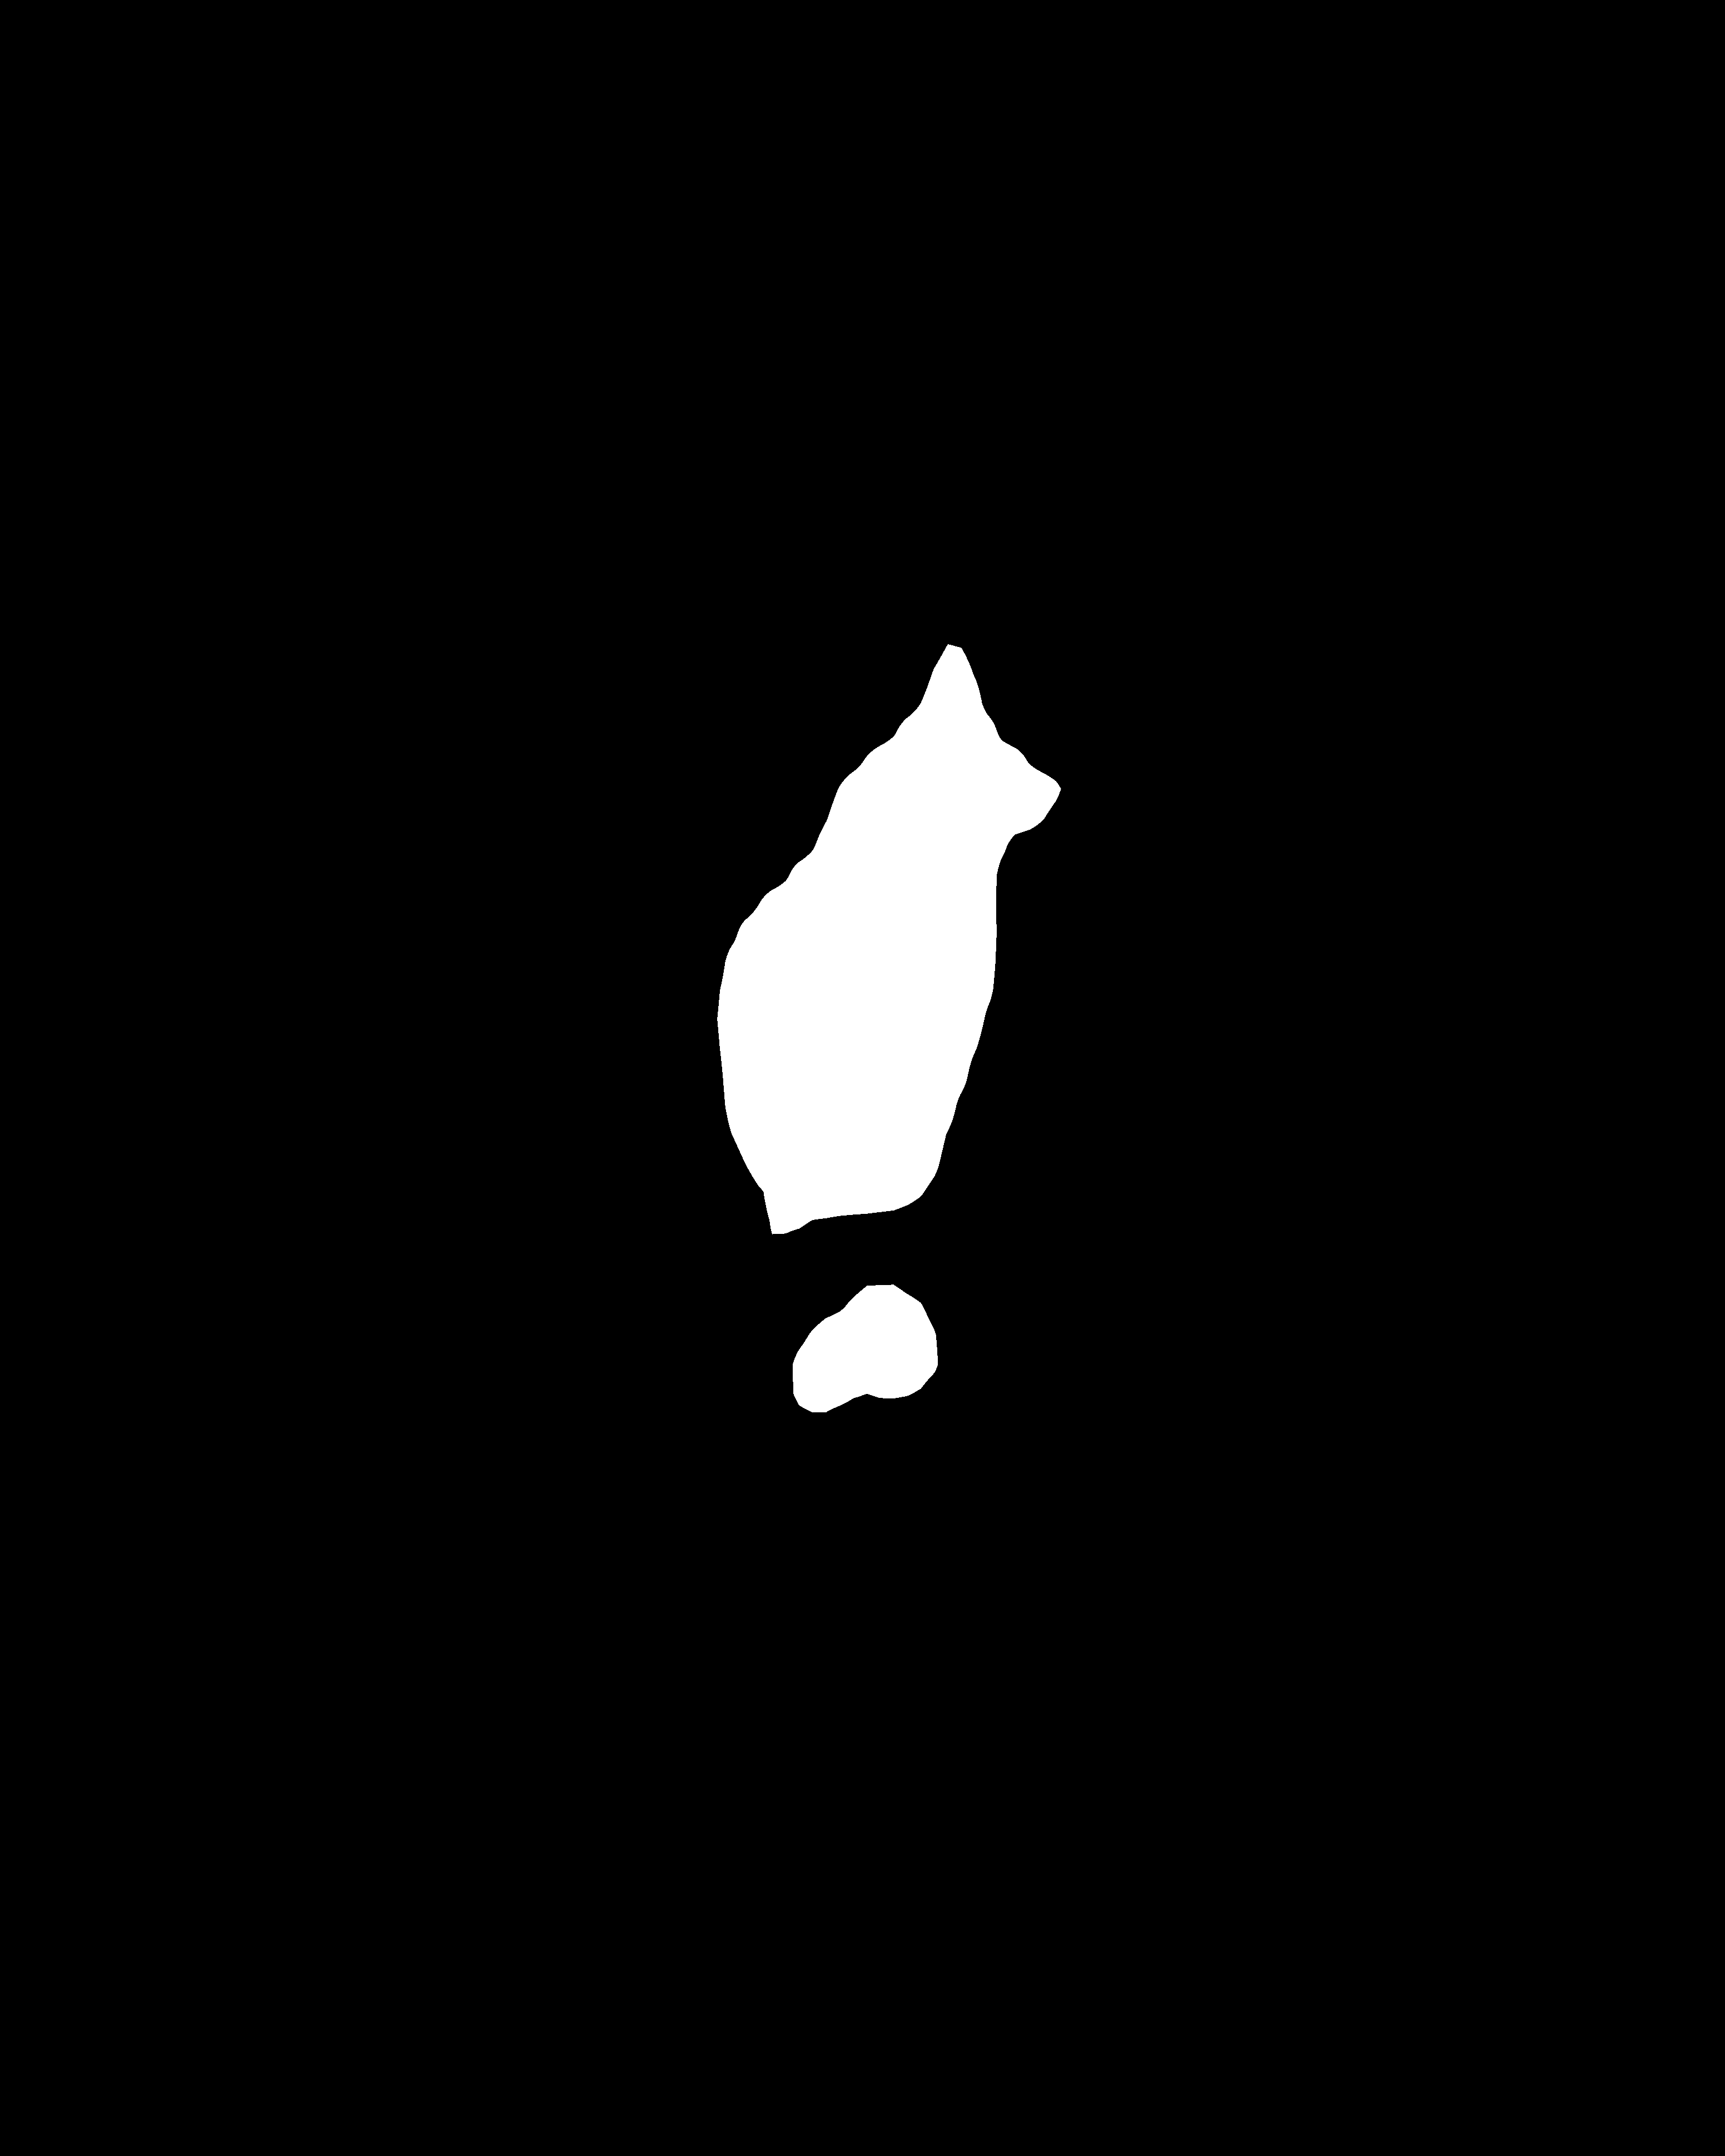

In [ ]:
cv2_imshow(mask)

Saving the mask ...

In [ ]:
_, ext = filename.rsplit('.', 1)
cv2.imwrite(filename.replace('.'+ext,'_mask.png'), mask)

True

In [ ]:
segments_info